# Report: Kameneva Lab Data Analysis Task

#### Preamble

I have chosen to work on the tasks using `Python` as it is the programming language I am most capable with.
As you will see, my results do not fully align with the analyses carried out in the Nature publication and  I am thinking
that might at least in part be due to differences in `R` and `Pyhton` package availability and implementations.

The comments and explanations about the code added in this report always reference the cells below unless otherwise stated.

Plots and results will be referred to below.

In some cases I will add a paragraph of methodical discussions in _italic_ as well.

In [1]:
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import numpy as np
import os

# sc.settings.verbosity = 2

I downloaded the files via the link you provided in the PDF document.

## Preprocess

In this section I am working on **Task 1**.

For this part of the tasks I mainly took inspiration from the Methods section of the paper you referred to in the assignment and from the [**scverse tutorial**](https://scverse-tutorials.readthedocs.io/en/latest/notebooks/basic-scrna-tutorial.html) that uses `scanPy`.

In [ ]:
data_dir = "./data/raw/"
h5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".h5")]

### Filter

In [5]:
samples = {}

for h5_file in h5_files:
    basename = os.path.basename(h5_file)
    sample_id = basename.split(".")[0].split("_")[-1]
    samples[sample_id] = h5_file

Usually I would filter for hemoglobing and ribosomal genes, but I prioritized sticking the publications preprocessing which only mentioned removal of >25% mitochondrial genes.

In [ ]:
for ix, (sample_id, filename) in enumerate(samples.items()):
    print(f"Processing file {ix + 1}/{len(samples)}: {sample_id}")

    sample_adata = sc.read_10x_h5(filename)
    sample_adata.var_names_make_unique()

    # filter for genes
    sc.pp.filter_cells(sample_adata, min_genes=200)
    sc.pp.filter_cells(sample_adata, max_genes=7000)

    # filter for more than 25% mitochondrial genes
    sample_adata.var["mt"] = sample_adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(sample_adata, qc_vars="mt", inplace=True, log1p=True)
    sample_adata = sample_adata[sample_adata.obs.pct_counts_mt < 25, :]
    
    # store the filtered data
    filtered_dir = "./data/filtered/"
    basename = os.path.basename(filename)
    basename = os.path.splitext(basename)[0]
    filtered_file = os.path.join(filtered_dir, f"{basename}_filtered.h5ad")
    sample_adata.write_h5ad(filtered_file)

### Combine

I am doing this in two steps because I only have 12GB RAM available and my kernel kept dying.

In [42]:
filtered_data_dir = "./data/filtered"
filtered_h5_files = [os.path.join(filtered_data_dir, f) for f in os.listdir(filtered_data_dir) if f.endswith(".h5ad")]

In [43]:
samples = {}

for h5_file in filtered_h5_files:
    basename = os.path.basename(h5_file)
    sample_id = basename.split(".")[0].split("_")[-1]
    samples[sample_id] = h5_file

In [11]:
adatas = {}

for ix, (sampled_id, filename) in enumerate(samples.items()):

    sample_adata = sc.read_h5ad(filename)
    sample_adata.var_names_make_unique()

    adatas[sampled_id] = sample_adata

# concatenate using outer to keep all genes and samples
adata = ad.concat(adatas, join="outer", label="sample")

combined_file = os.path.join(filtered_data_dir, "combined_filtered.h5ad")
adata.write_h5ad(combined_file)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


The combined data set leaves us with **146,273** cells.

### Feature Selection

In [2]:
adata = sc.read_h5ad('/home/enno/code/scAnalysis/data/merged/combined_filtered.h5ad')
adata.obs_names_make_unique()

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True, flavor="seurat_v3", subset=True, batch_key="sample")

### Regress out counts, percent mitochondrial and cell cycle 

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [5]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [6]:
# Inspired by the scanpy usage example:
# https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

       'DTL', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1',
       'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'RAD51',
       'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1',
       'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'],
      dtype='object')
       'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'CDCA2', 'PSRC1', 'LBR',
       'CKAP5', 'CTCF', 'G2E3', 'GAS2L3', 'CBX5'],
      dtype='object')


In [ ]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

In [ ]:
# store as h5ad
adata.write_h5ad('./data/merged/cleaned.h5ad')

## Cluster Analysis

This section deals with Tasks 2, 3, and 4 of the assignment.

In [2]:
adata = sc.read_h5ad('data/merged/cleaned.h5ad')

### PCA

[<Axes: title={'center': 'phase'}, xlabel='PC1', ylabel='PC2'>,
 <Axes: title={'center': 'sample'}, xlabel='PC1', ylabel='PC2'>]

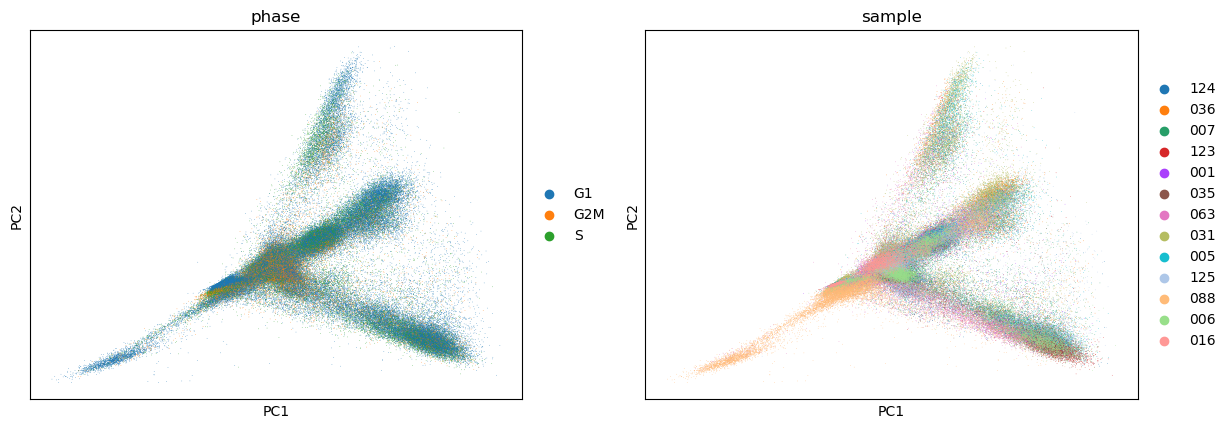

In [3]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color=['phase', 'sample'], use_raw=False, show=False)

PCA plot of the data color coded by cell cylce phase (left) and sample id (right). We see that the cell cylce phase is not a driving factor in the variance of the data.

In [ ]:
# Variance ratio plot
sc.pl.pca_variance_ratio(adata, log=False, show=False)

... however this has to be taken with a grain of salt as only baout 7% of variance is explained through the first two Principle Components.

### UMAP

In [7]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)
sc.tl.umap(adata)

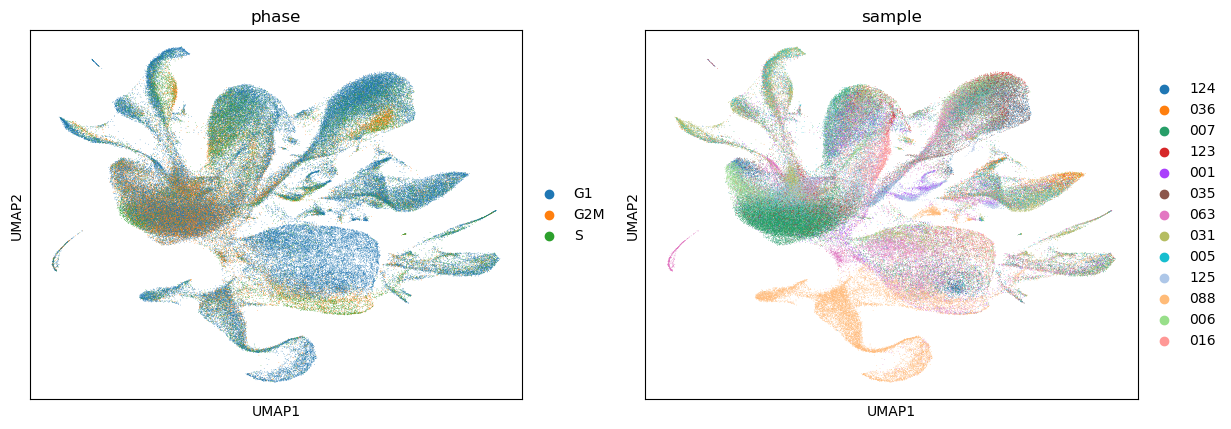

In [8]:
sc.pl.umap(adata, color=['phase', 'sample'], use_raw=False)

### Clustering

In [9]:
# clustering
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=15)
sc.tl.leiden(adata, flavor="igraph", resolution=0.3)

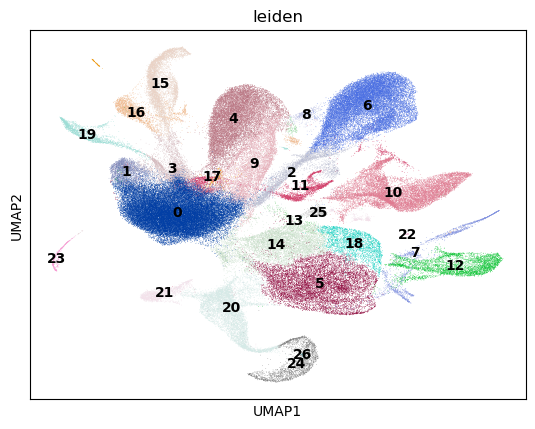

In [10]:
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

### Marker Gene Expression

In [8]:
genes = [
    "PECAM1", "KDR", "PRRX1", "GATA4", "HAND2", "HNF4A", 
    "SPINK2", "AZU1", "FCGR1A", "CD163", "HBA2", "HBB", 
    "MITF", "PAX2", "NR5A1", "SOX10", "PLP1", "FOXD3", 
    "ELAVL3", "ELAVL4", "PHOX2B", "TH", "STMN2"
]

for gene in genes:
    is_in_data = gene in adata.var_names

    if not is_in_data:
        print(f"{gene} not in data")
        continue

GATA4 not in data
HNF4A not in data
FCGR1A not in data
ELAVL3 not in data


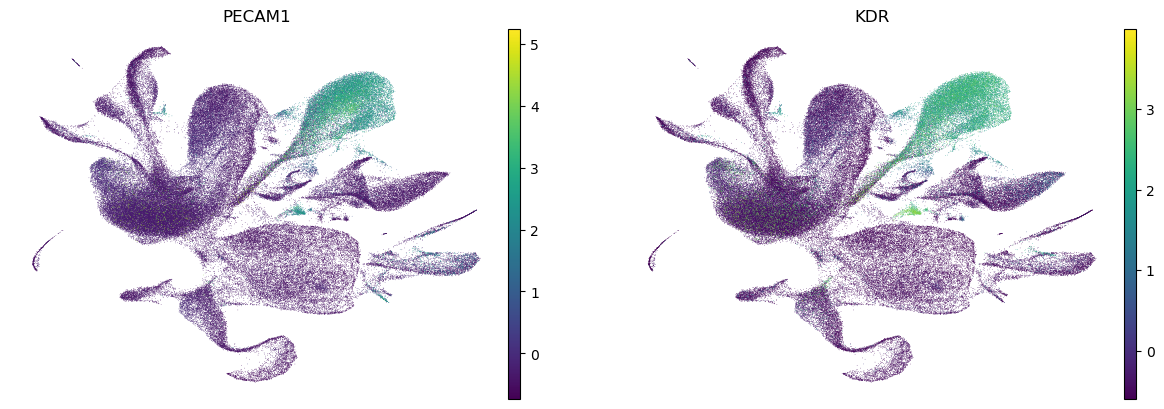

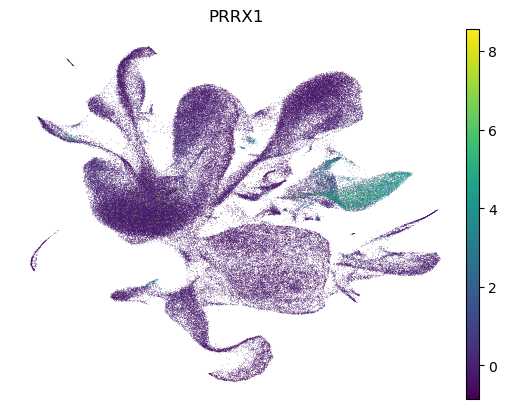

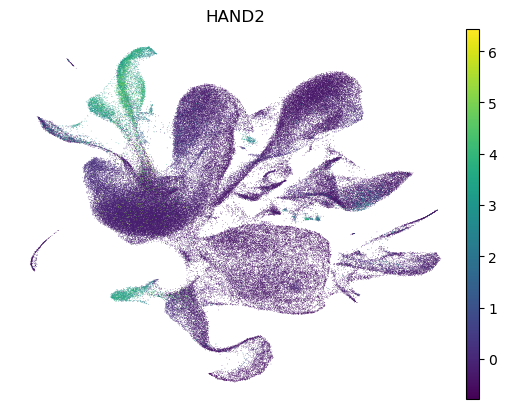

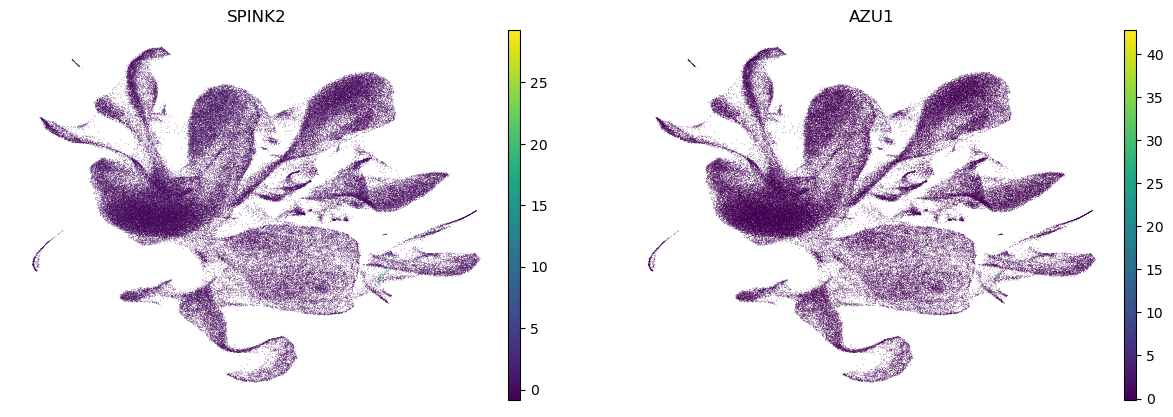

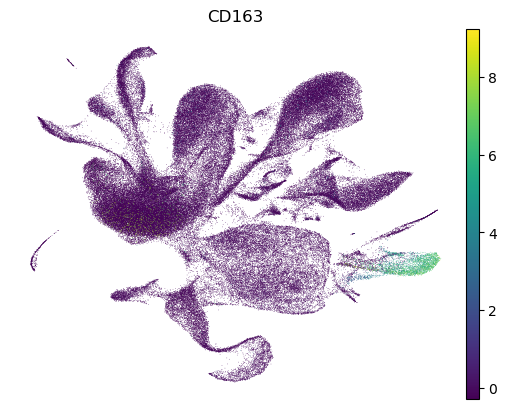

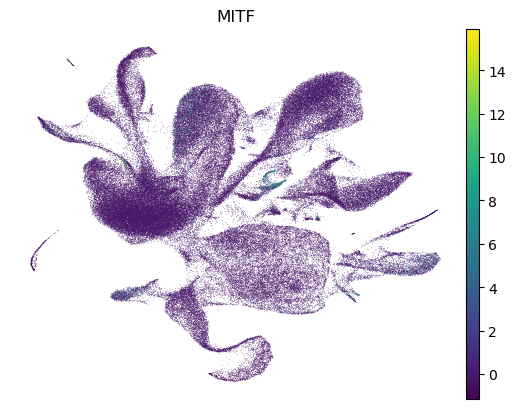

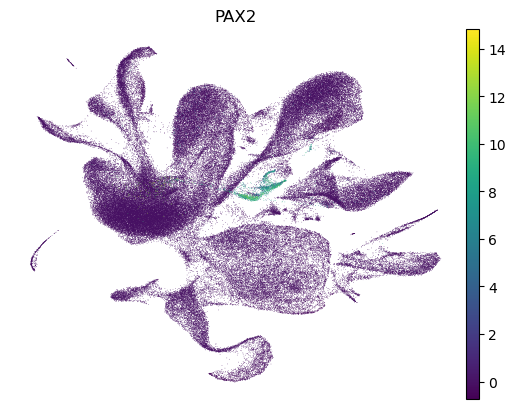

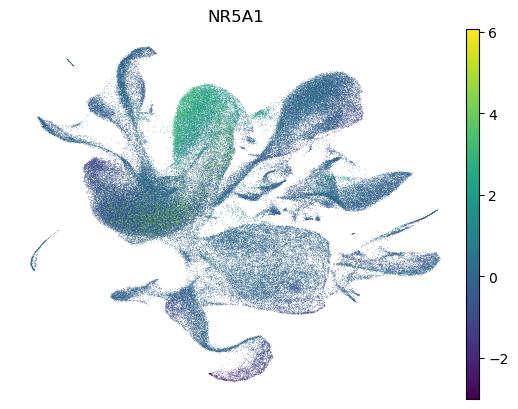

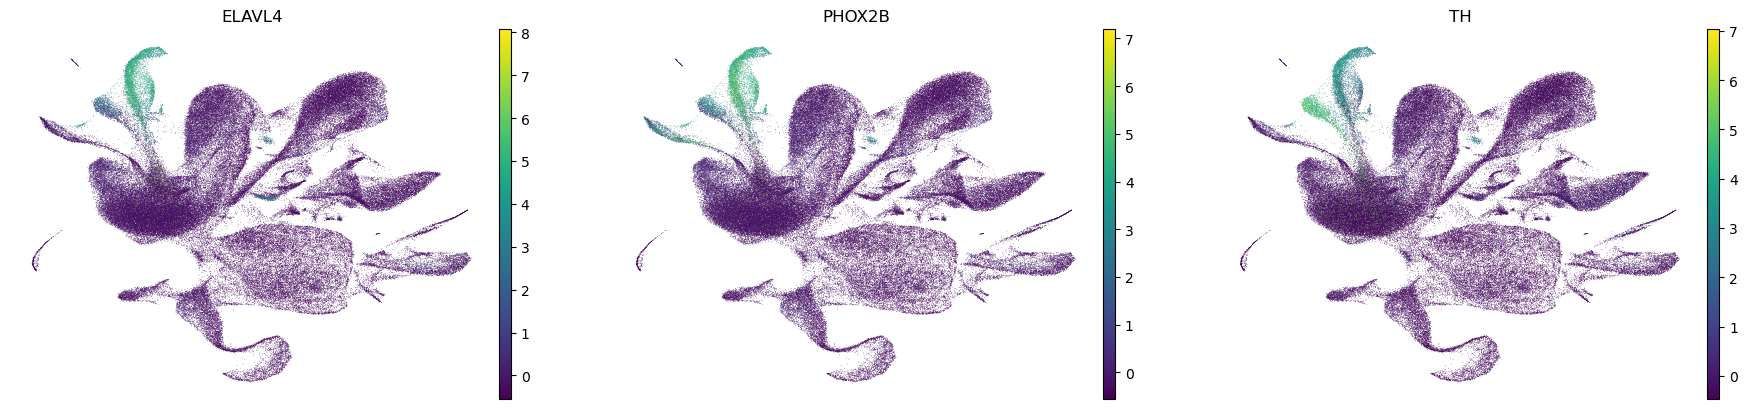

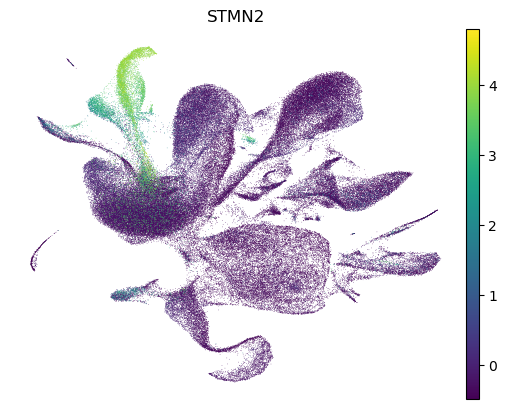

In [11]:
# UMAP with genes: PECAM1, KDR
sc.pl.umap(adata, color=['PECAM1', 'KDR'], use_raw=False, frameon=False)

# UMAP with genes: PRRX1
sc.pl.umap(adata, color=['PRRX1'], use_raw=False, frameon=False)

# UMAP with genes: GATA4, HAND2
sc.pl.umap(adata, color=['HAND2'], use_raw=False, frameon=False)

# UMAP with genes: HNF4A
# sc.pl.umap(adata, color=['HNF4A'], use_raw=False, frameon=False)

# UMAP with genes: SPINK2, AZU1
sc.pl.umap(adata, color=['SPINK2', 'AZU1'], use_raw=False, frameon=False)

# UMAP with genes: FCGR1A, CD163
sc.pl.umap(adata, color=['CD163'], use_raw=False, frameon=False)

# UMAP with genes: HBA2, HBB
sc.pl.umap(adata, color=['HBA2', 'HBB'], use_raw=False, frameon=False)

# UMAP with genes: MITF
sc.pl.umap(adata, color=['MITF'], use_raw=False, frameon=False)

# UMAP with genes: PAX2
sc.pl.umap(adata, color=['PAX2'], use_raw=False, frameon=False)

# UMAP with genes: NR5A1
sc.pl.umap(adata, color=['NR5A1'], use_raw=False, frameon=False)

# UMAP with genes: SOX10, PLP1, FOXD3
sc.pl.umap(adata, color=['SOX10', 'PLP1', 'FOXD3'], use_raw=False, frameon=False)

# UMAP with genes: ELAVL3, ELAVL4, PHOX2B, TH
sc.pl.umap(adata, color=['ELAVL4', 'PHOX2B','TH'], use_raw=False, frameon=False)

# UMAP with genes: STMN2
sc.pl.umap(adata, color=['STMN2'], use_raw=False, frameon=False)

### Differentially Expressed Genes

In [44]:
# https://github.com/scverse/scverse-tutorials/blob/main/docs/notebooks/basic-scrna-tutorial.ipynb

In [ ]:
# top 5 differential expressed genes per cluster
sc.tl.rank_genes_groups(adata, 'leiden', )

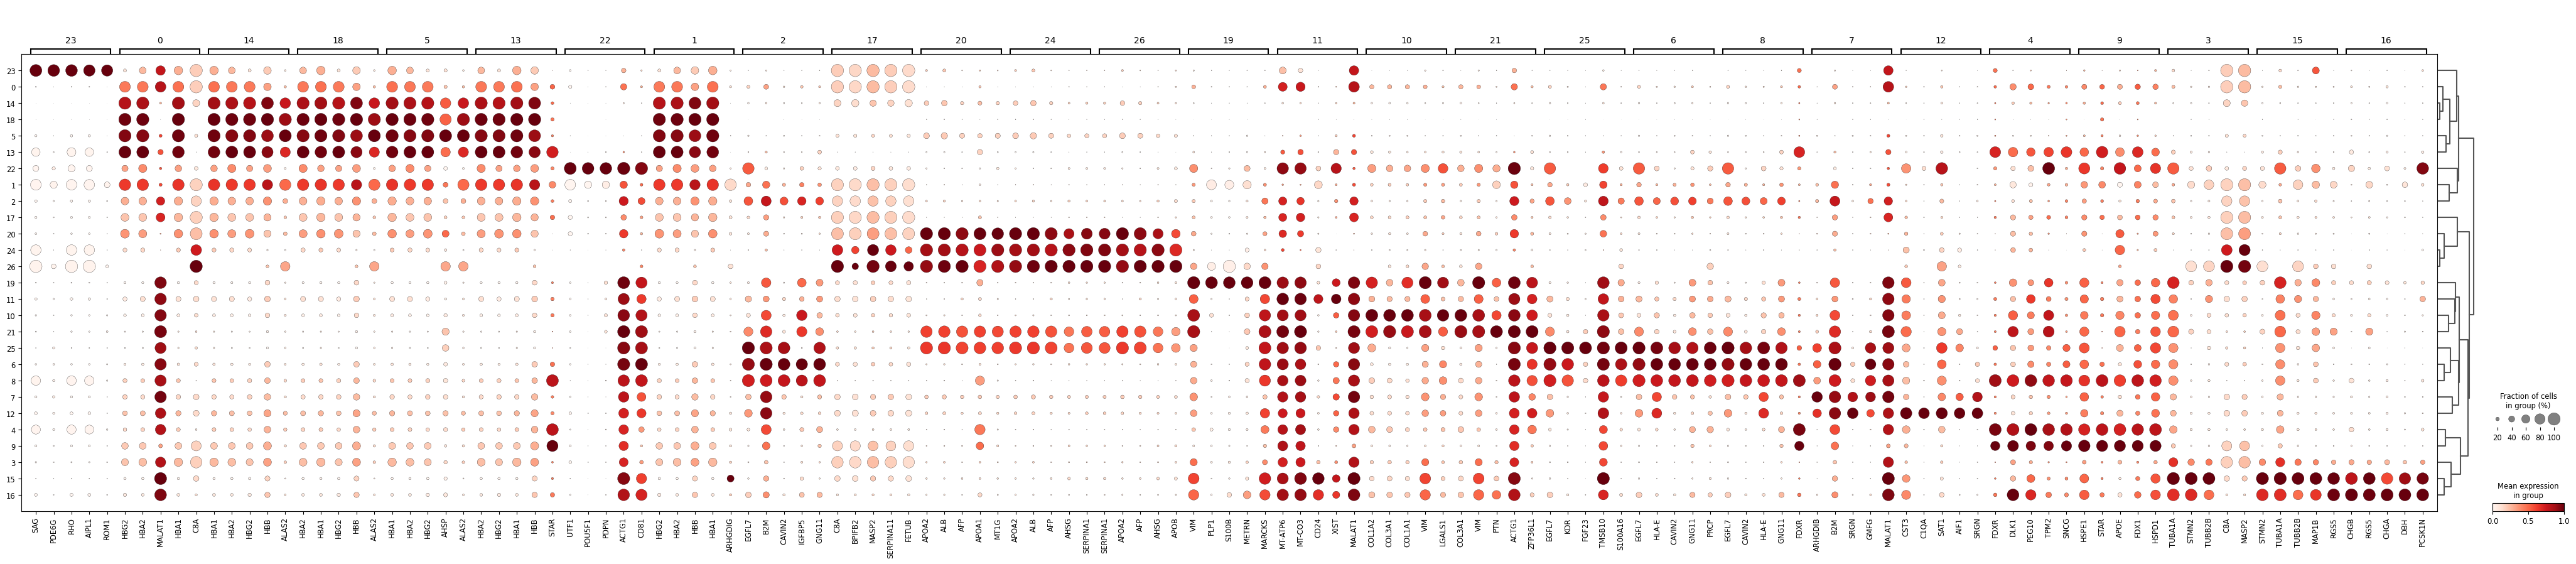

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

In [ ]:
# write
adata.write_h5ad('./data/merged/cleaned_w_cluster.h5ad')

## Re-cluster

In [14]:
# confine analysis on clusters 15, 16, 19
adata = adata[adata.obs['leiden'].isin(['3', '15', '16', '19'])]

In [15]:
# remove sample id 036 since it is an extra-adrenal sample
adata = adata[adata.obs['sample'] != '036']
adata.shape

(11766, 2000)

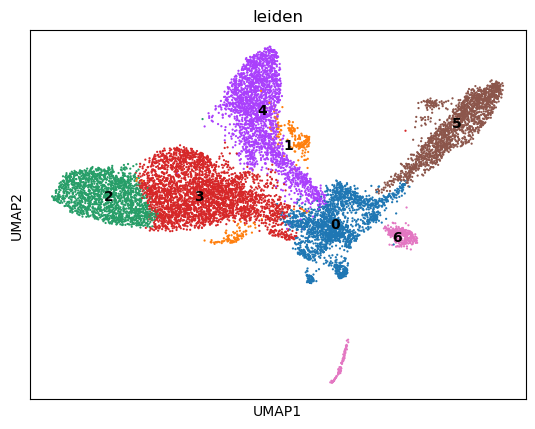

In [18]:
# cluster
sc.pp.neighbors(adata, n_neighbors=200, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.3)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

In [19]:
# remove 11 12 13 since they are disconnected
adata = adata[~adata.obs['leiden'].isin(['6'])]

In [20]:
# re-run PCA, neighbors, UMAP
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=200, n_pcs=15)
sc.tl.umap(adata)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


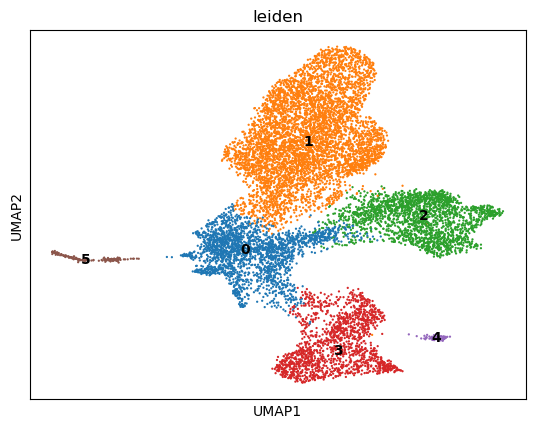

In [21]:
# re-run Leiden and plot
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

In [22]:
# remove 11 12 13 since they are disconnected
adata = adata[~adata.obs['leiden'].isin(['5', '4'])]

In [23]:
# re-run Leiden and plot
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


In [24]:
# trajectory analysis
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, threshold=0.03, show=True)

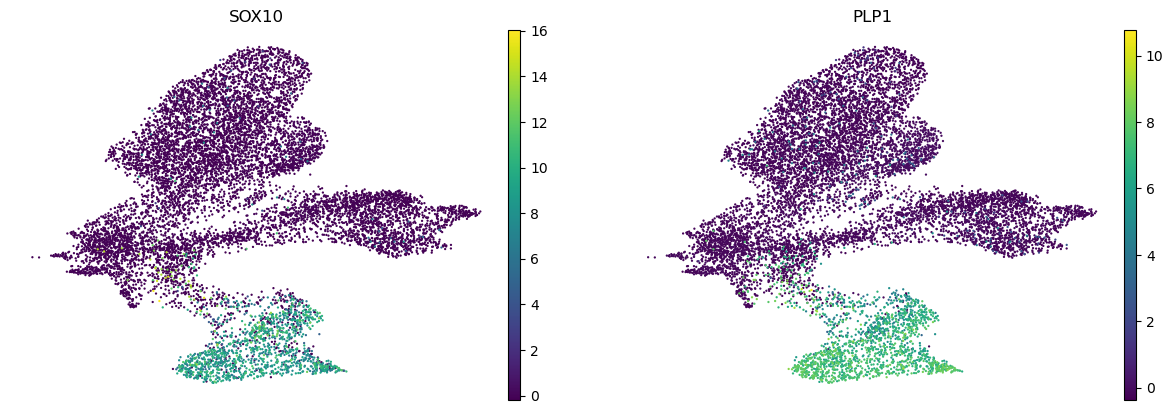

In [25]:
# SCPs
sc.pl.umap(adata, color=['SOX10', 'PLP1'], use_raw=False, frameon=False)  # 'FOXD3'

# Symphatoblasts
sc.pl.umap(adata, color=['ELAVL4', 'PRPH'], use_raw=False, frameon=False) #  'ISL1'

# Chromaffin cells
sc.pl.umap(adata, color=['CHGA', 'PNMT'], use_raw=False, frameon=False)  # STMN2

# Cell cycle genes
# sc.pl.umap(adata, color=['MKI67', 'TOP2A', 'TUBB4B'], use_raw=False, frameon=False)

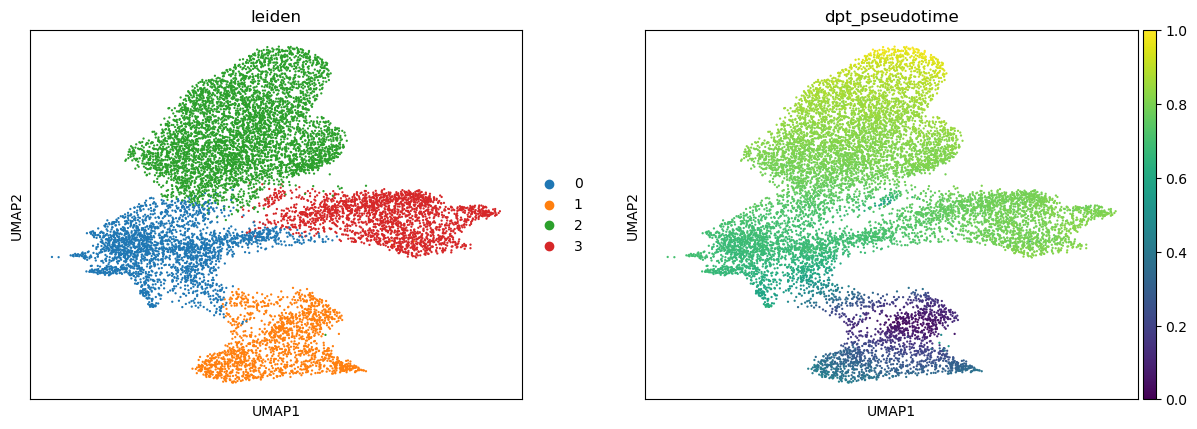

In [26]:
# https://nbisweden.github.io/workshop-scRNAseq/labs/scanpy/scanpy_07_trajectory.html#gene-changes

# Choose a root cell or cluster
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden'] == '1')[0]

# Compute diffusion pseudotime
sc.tl.dpt(adata)

# Plot pseudotime
sc.pl.umap(adata, color=['leiden', 'dpt_pseudotime'], show=True)


In [28]:
# Define paths

paths = [('P1', ['1', '0', '2']),
         ('P2', ['1', '0', '3']),
         ('P3', ['1', '0', '2', '3']),
         ('P4', ['1', '0', '3', '2']),
         ]

adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [29]:
gene_names = ['SOX10', 'PLP1', 'FOXD3', 'ELAVL4', 'PRPH', 'ISL1', 'CHGA', 'PNMT', 'STMN2']

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1283: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1332: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


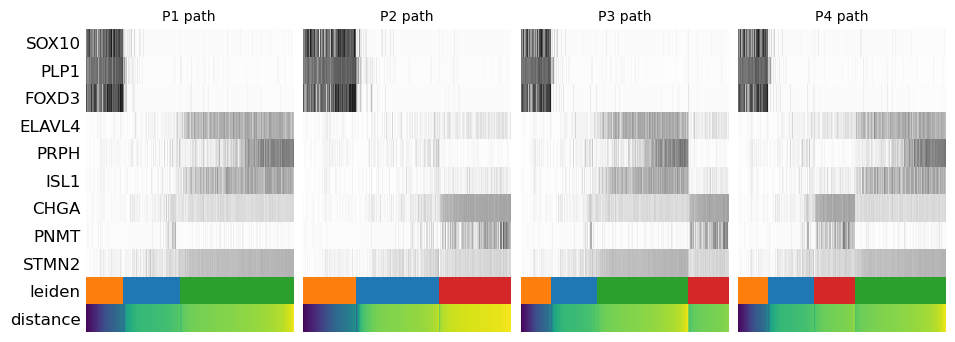

In [30]:
_, axs = plt.subplots(ncols=4, figsize=(10, 4), gridspec_kw={
                     'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(
        adata=adata, 
        nodes=path, 
        keys=gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=10,
        annotations=['distance'],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map='Greys',
        # groups_key='annot',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        use_raw=False,
        show=False)

plt.show()